Diana Covaci, 261 086 280

Nicholas Milin, 261 106 314

Viktor Allais, 261 148 866

In [ ]:
!pip install -q numpy pandas matplotlib seaborn scikit-learn ucimlrepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import itertools
from IPython.core.debugger import set_trace
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import combinations

# Model Implementations

## Gradient Descent

In [ ]:
class GradientDescent:

    def __init__(self, learning_rate=.01, max_iters=1e4, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        if record_history:
            self.w_history = []

    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        while t < self.max_iters:
            grad = gradient_fn(x, y, w)
            w = w - self.learning_rate * grad

            if self.record_history:
                self.w_history.append(w.copy())

            t += 1

        # print(grad)

        # if self.epsilon >= np.linalg.norm(grad):
        #     print("Warning: Gradient Descent did not converge because of Epsilon")
        # if t >= self.max_iters:
        #     print(f"Gradient Descent converged in {t} iterations")

        return w

## Linear Regression

In [ ]:
class LinearRegression:
    def __init__(self, add_bias=True, lambda1:float=0, lambda2:float=0):
        self.add_bias = add_bias
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        pass

    def gradient(self, x, y, w):
        N, D = x.shape
        yh =  np.dot(x, w)
        grad = np.dot(x.T, (yh - y))/N

        if self.add_bias: # Bias term is the last added one so use [:-1] instead of [1:]
            grad[:-1] += self.lambda1 * np.sign(w[:-1]) + self.lambda2 * w[:-1]
        else:
            grad += self.lambda1 * np.sign(w) + self.lambda2 * w
        return grad

    def fit(self, x, y, optimizer=None):
        if x.ndim == 1:
            x = x[:, None]

        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])

        N, D = x.shape

        if optimizer is None:
            xtx = np.dot(x.T, x)
            xtx_inv = np.linalg.pinv(xtx)
            xty = np.dot(x.T, y)
            self.w = np.dot(xtx_inv, xty)
        else:
            w0 = np.zeros(D)                       # initialize the weights to 0
            self.w = optimizer.run(self.gradient, x, y, w0)      # run the optimizer to get the optimal weights
        return self

    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x, np.ones(x.shape[0])])
        yh = x@self.w
        return yh

    def SSE(self, y, yh):
        l1_penalty = self.lambda1 * np.sum(np.abs(self.w))
        l2_penalty = self.lambda2 * np.dot(self.w,self.w)/2
        return np.sum((y - yh)**2) + l1_penalty + l2_penalty

    def MSE(self, y, yh):
        l1_penalty = (self.lambda1 * np.sum(np.abs(self.w))) / len(y)
        l2_penalty = (self.lambda2 * np.dot(self.w,self.w)/2) / len(y)
        return np.mean((y - yh)**2) + l1_penalty + l2_penalty

## Cross Validate

In [ ]:
def cross_validate(n, n_folds=10, seed=0):
    np.random.seed(seed)
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

# Task 1: Linear Regression with Non-Linear Basis Functions

## 1.1: Data Generation

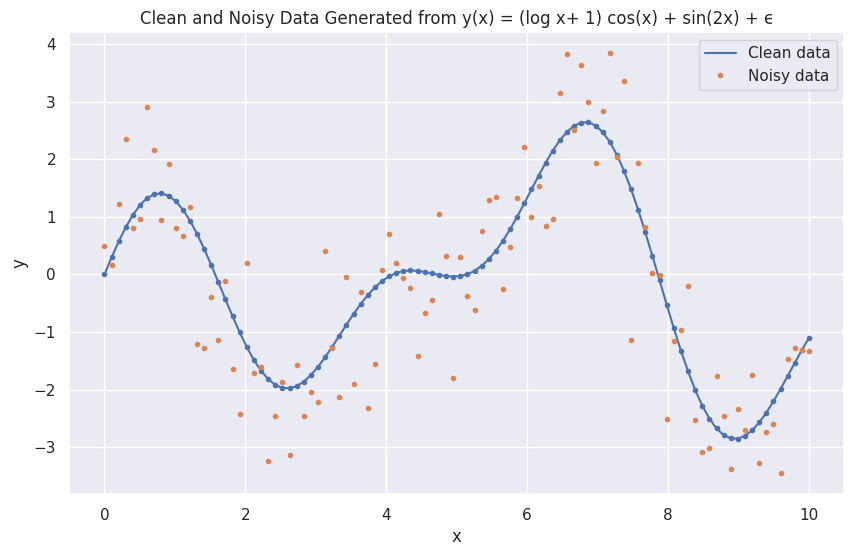

In [ ]:
N = 100 # Number of data points
x = np.linspace(0,10, N) # 100 points 0-10 uniformly

# Generate clean y values
y_clean = (np.log(x + 1) * np.cos(x) + np.sin(2 * x))

np.random.seed(42)
# Generate noisy y values
epsilon = np.random.randn(N) # Gaussian noise with mean 0 and variance 1
y_noisy = y_clean + epsilon

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x, y_clean, ".")
plt.plot(x, y_clean, 'b-', label='Clean data')
plt.plot(x, y_noisy, ".", label='Noisy data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Clean and Noisy Data Generated from y(x) = (log x+ 1) cos(x) + sin(2x) + ϵ')
plt.legend()
plt.show()

## 1.2: Non-Linear Basis Functions

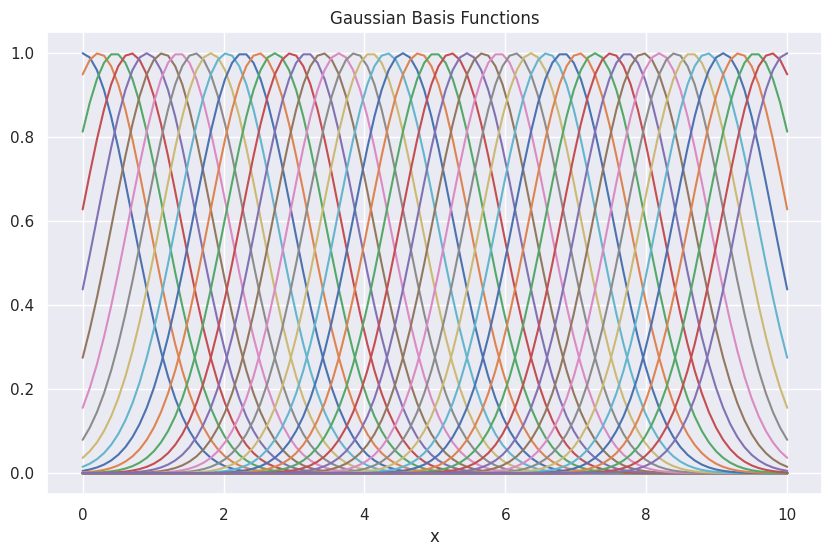

In [ ]:
def gaussian_basis_function(x, mu, sigma=1):
    return np.exp(-(x - mu)**2 / sigma**2)

D = 45 # Number of basis functions
xmin = x.min()
xmax = x.max()
mu = xmin + (xmax - xmin) / (D - 1) * np.arange(D)

# Calculate the basis function values for all x and all mus
phi = gaussian_basis_function(x[:, None], mu[None, :])

# Plot the Gaussian basis functions
plt.figure(figsize=(10, 6))
for d in range(D):
    plt.plot(x, phi[:,d], '-')

plt.xlabel('x')
plt.title('Gaussian Basis Functions')
plt.grid(True)
plt.show()

## 1.3: Model Fitting

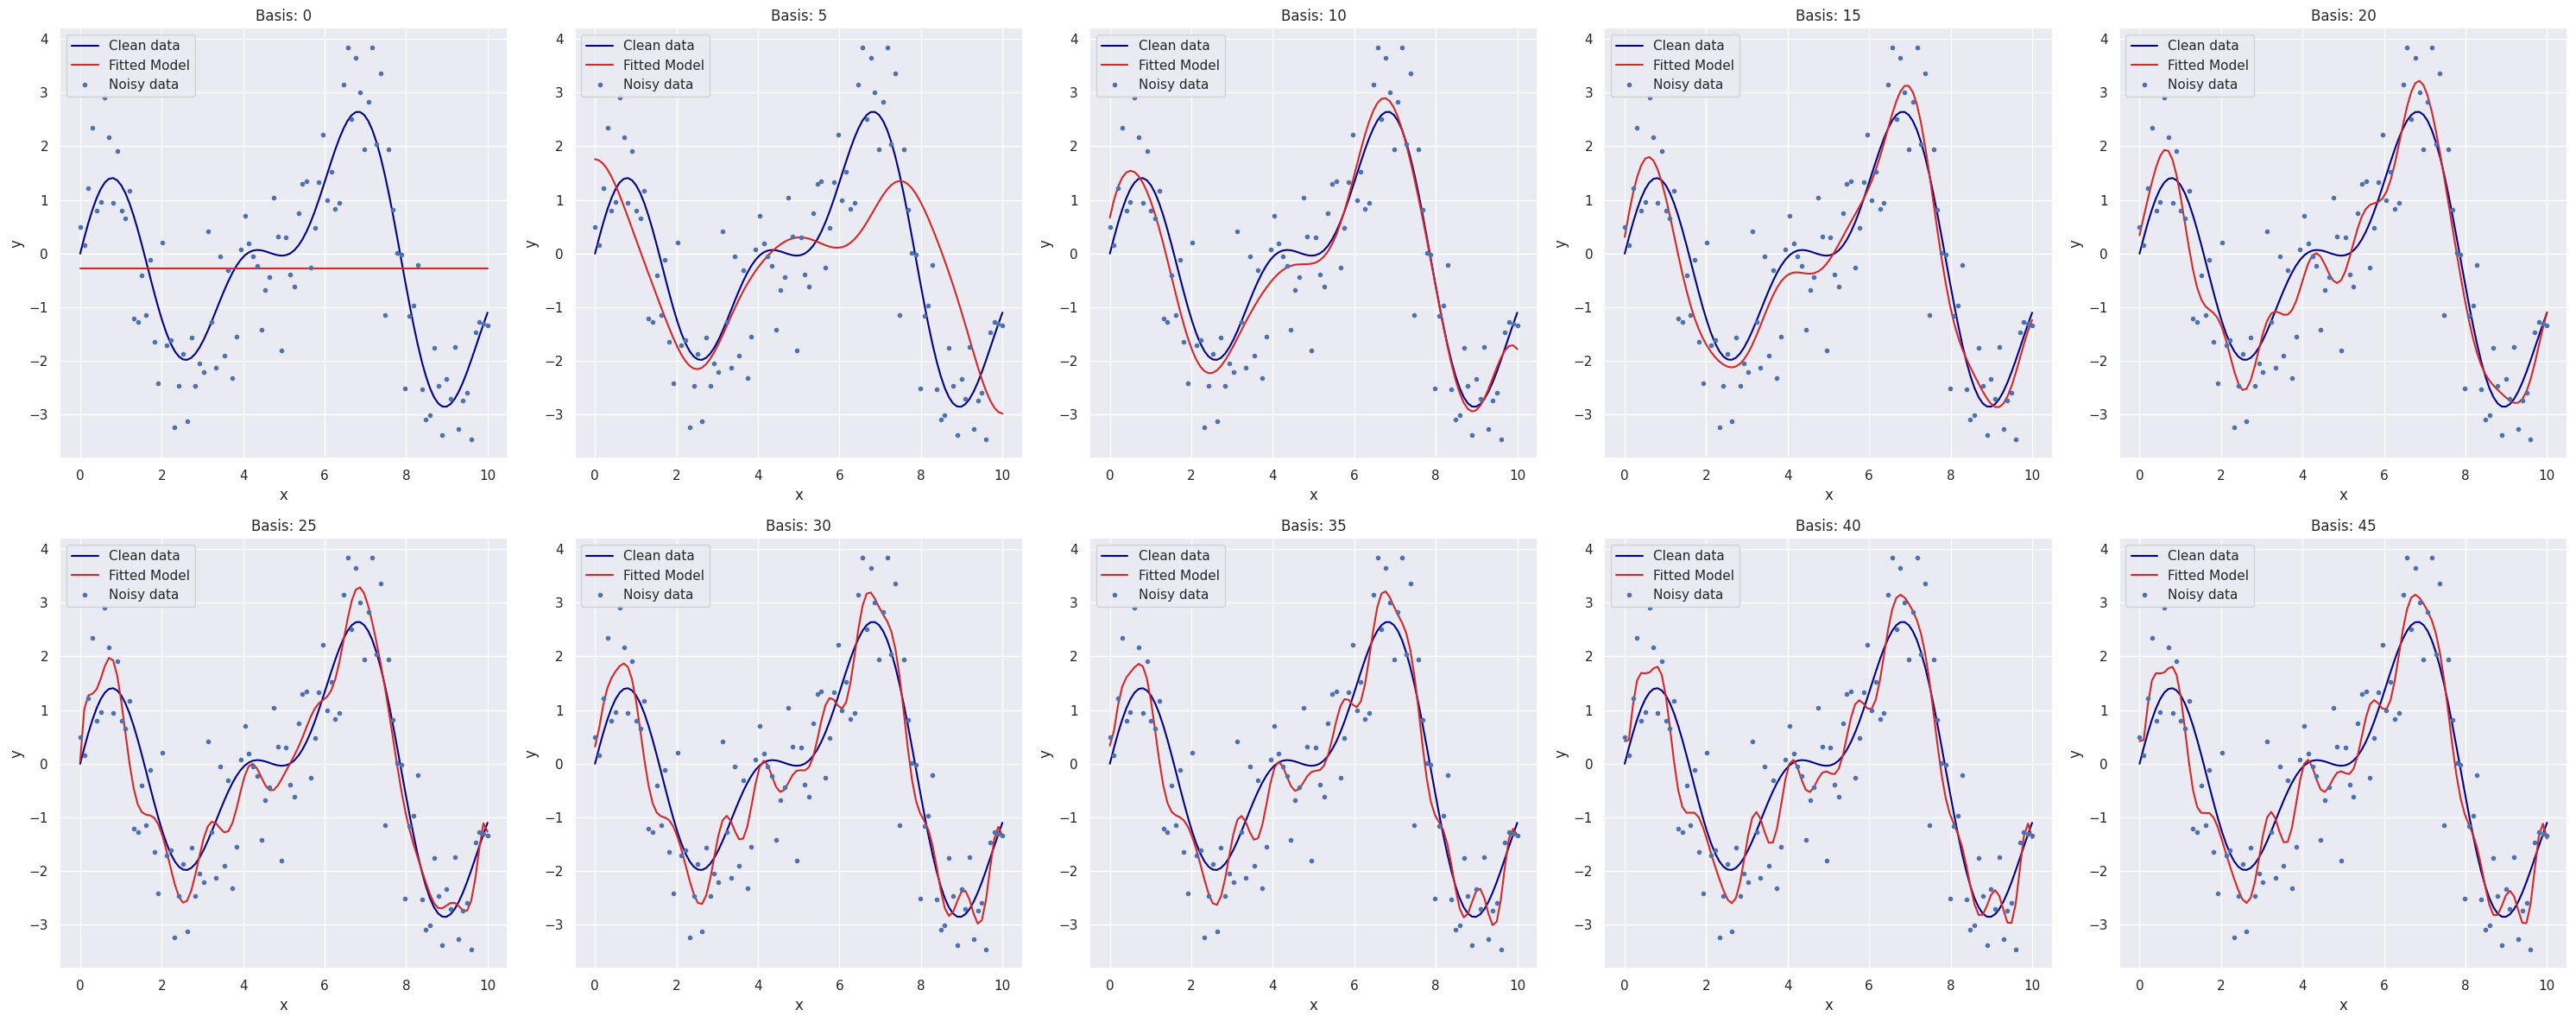

In [ ]:
bases = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
fig, axs = plt.subplots(2, 5, figsize=(30, 12))

model = LinearRegression()
for i, base in enumerate(bases):
    row = i // 5
    col = i % 5
    ax = axs[row, col]

    # Use entire x since we are fitting to the entire max
    xmin = x.min()
    xmax = x.max()
    mu = xmin + (xmax - xmin) / (base - 1) * np.arange(base) if base != 1 else np.array([0])
    phi = gaussian_basis_function(x[:, None], mu[None, :])

    yh = model.fit(phi, y_noisy).predict(phi)

    ax.plot(x, y_clean, '-', label="Clean data", color='darkblue')
    ax.plot(x, yh, '-', label="Fitted Model", color='tab:red')
    ax.plot(x, y_noisy, "b.", label="Noisy data")

    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"Basis: {base}")

plt.tight_layout()
plt.show()

## 1.4: Model Selection

In [ ]:
x_train, x_validation, y_train, y_validation = train_test_split(x, y_noisy, test_size=0.2, random_state=42)

column_names = ['Num. Bases', 'Train SSE', 'Validation SSE']
df = pd.DataFrame()

bases = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]


for base in bases:
    # Use only x_train for min and max
    xmin = x_train.min()
    xmax = x_train.max()
    mu = xmin + (xmax - xmin) / (base - 1) * np.arange(base) if base > 1 else np.array([0])

    phi_train = gaussian_basis_function(x_train[:, None], mu[None, :])
    phi_validation = gaussian_basis_function(x_validation[:, None], mu[None, :])

    model = LinearRegression()
    model.fit(phi_train, y_train)

    yh = model.predict(phi_train)
    train_sse = model.SSE(y_train, yh)

    yh = model.predict(phi_validation)
    validation_sse = model.SSE(y_validation, yh)

    new_row = pd.DataFrame([[base, round(train_sse,2), round(validation_sse,2)]], columns=column_names)
    df = pd.concat([df, new_row], ignore_index=True)

display(df)

print("The Validation is minimized at base 10")
print("\nTo gain a more percise base, we will check bases from 5-15\n")
bases = [x for x in range(5,16)]

df = pd.DataFrame()
for base in bases:
    xmin = x_train.min()
    xmax = x_train.max()
    mu = xmin + (xmax - xmin) / (base - 1) * np.arange(base) if base > 1 else np.array([0])

    phi_train = gaussian_basis_function(x_train[:, None], mu[None, :])
    phi_validation = gaussian_basis_function(x_validation[:, None], mu[None, :])

    model = LinearRegression()
    model.fit(phi_train, y_train)

    yh = model.predict(phi_train)
    train_sse = model.SSE(y_train, yh)

    yh = model.predict(phi_validation)
    validation_sse = model.SSE(y_validation, yh)

    new_row = pd.DataFrame([[base, round(train_sse,2), round(validation_sse,2)]], columns=column_names)
    df = pd.concat([df, new_row], ignore_index=True)

display(df)

print("From this, we can see the validation SEE is minimized at base=11")

Num. Bases  Train SSE  Validation SSE
0           0     263.76           53.60
1           5     159.14           36.84
2          10      62.08           14.16
3          15      57.31           17.08
4          20      51.86           20.93
5          25      49.35           39.12
6          30      48.45           28.58
7          35      48.45           28.03
8          40      48.45           27.85
9          45      48.46           27.77

The Validation is minimized at base 10

To gain a more percise base, we will check bases from 5-15



Num. Bases  Train SSE  Validation SSE
0            5     159.14           36.84
1            6     131.62           38.48
2            7      79.25           23.37
3            8      68.46           13.73
4            9      67.83           12.90
5           10      62.08           14.16
6           11      61.96           12.77
7           12      61.94           14.00
8           13      60.60           15.16
9           14      58.31           15.88
10          15      57.31           17.08

From this, we can see the validation SEE is minimized at base=11


## 1.5: Explanation

**Note:** See Section 2.1 of the report for detailed explanations.

# Task 2: Bias-Variance Tradeoff with Multiple Fits

## 1.1 Repeating the Process

In [ ]:
y_clean = (np.log(x + 1) * np.cos(x) + np.sin(2 * x))
# Function to generate noisy data -- especially useful in Task 2
def generate_noisy_data(seed, N=100):
  # N is the number of data points
  x = np.linspace(0,10,N) # 100 points 0-10 uniformly
  rng = np.random.default_rng(seed)
  epsilon = rng.normal(size=N)
  y_noisy = y_clean + epsilon
  return x, y_noisy


num_repetitions = 10
bases = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
results = {}

for base in bases:
  column_names = ['Num. Repetition', 'Train MSE', 'Validation MSE', 'y_pred']
  df = pd.DataFrame()
  for rep in range(num_repetitions):
    x, y_noisy = generate_noisy_data(seed=rep+base)
    x_train, x_validation, y_train, y_validation = train_test_split(x, y_noisy, test_size=0.2, random_state=42)
    model = LinearRegression()
    xmin = x_train.min()
    xmax = x_train.max()
    mu = xmin + (xmax - xmin) / (base - 1) * np.arange(base) if base > 1 else np.array([0])

    phi_train = gaussian_basis_function(x_train[:, None], mu[None, :])
    phi_validation = gaussian_basis_function(x_validation[:, None], mu[None, :])
    phi_full = gaussian_basis_function(x[:, None], mu[None, :])

    model.fit(phi_train, y_train)

    yh = model.predict(phi_train)
    train_mse = model.MSE(y_train, yh)

    yh = model.predict(phi_validation)
    validation_mse = model.MSE(y_validation, yh)

    yh_full = model.predict(phi_full)

    new_row = pd.DataFrame([[rep, train_mse, validation_mse, yh_full]], columns=column_names)
    df = pd.concat([df, new_row], ignore_index=True)
  results[base] = df


## 2.2 Plotting Multiple Fits

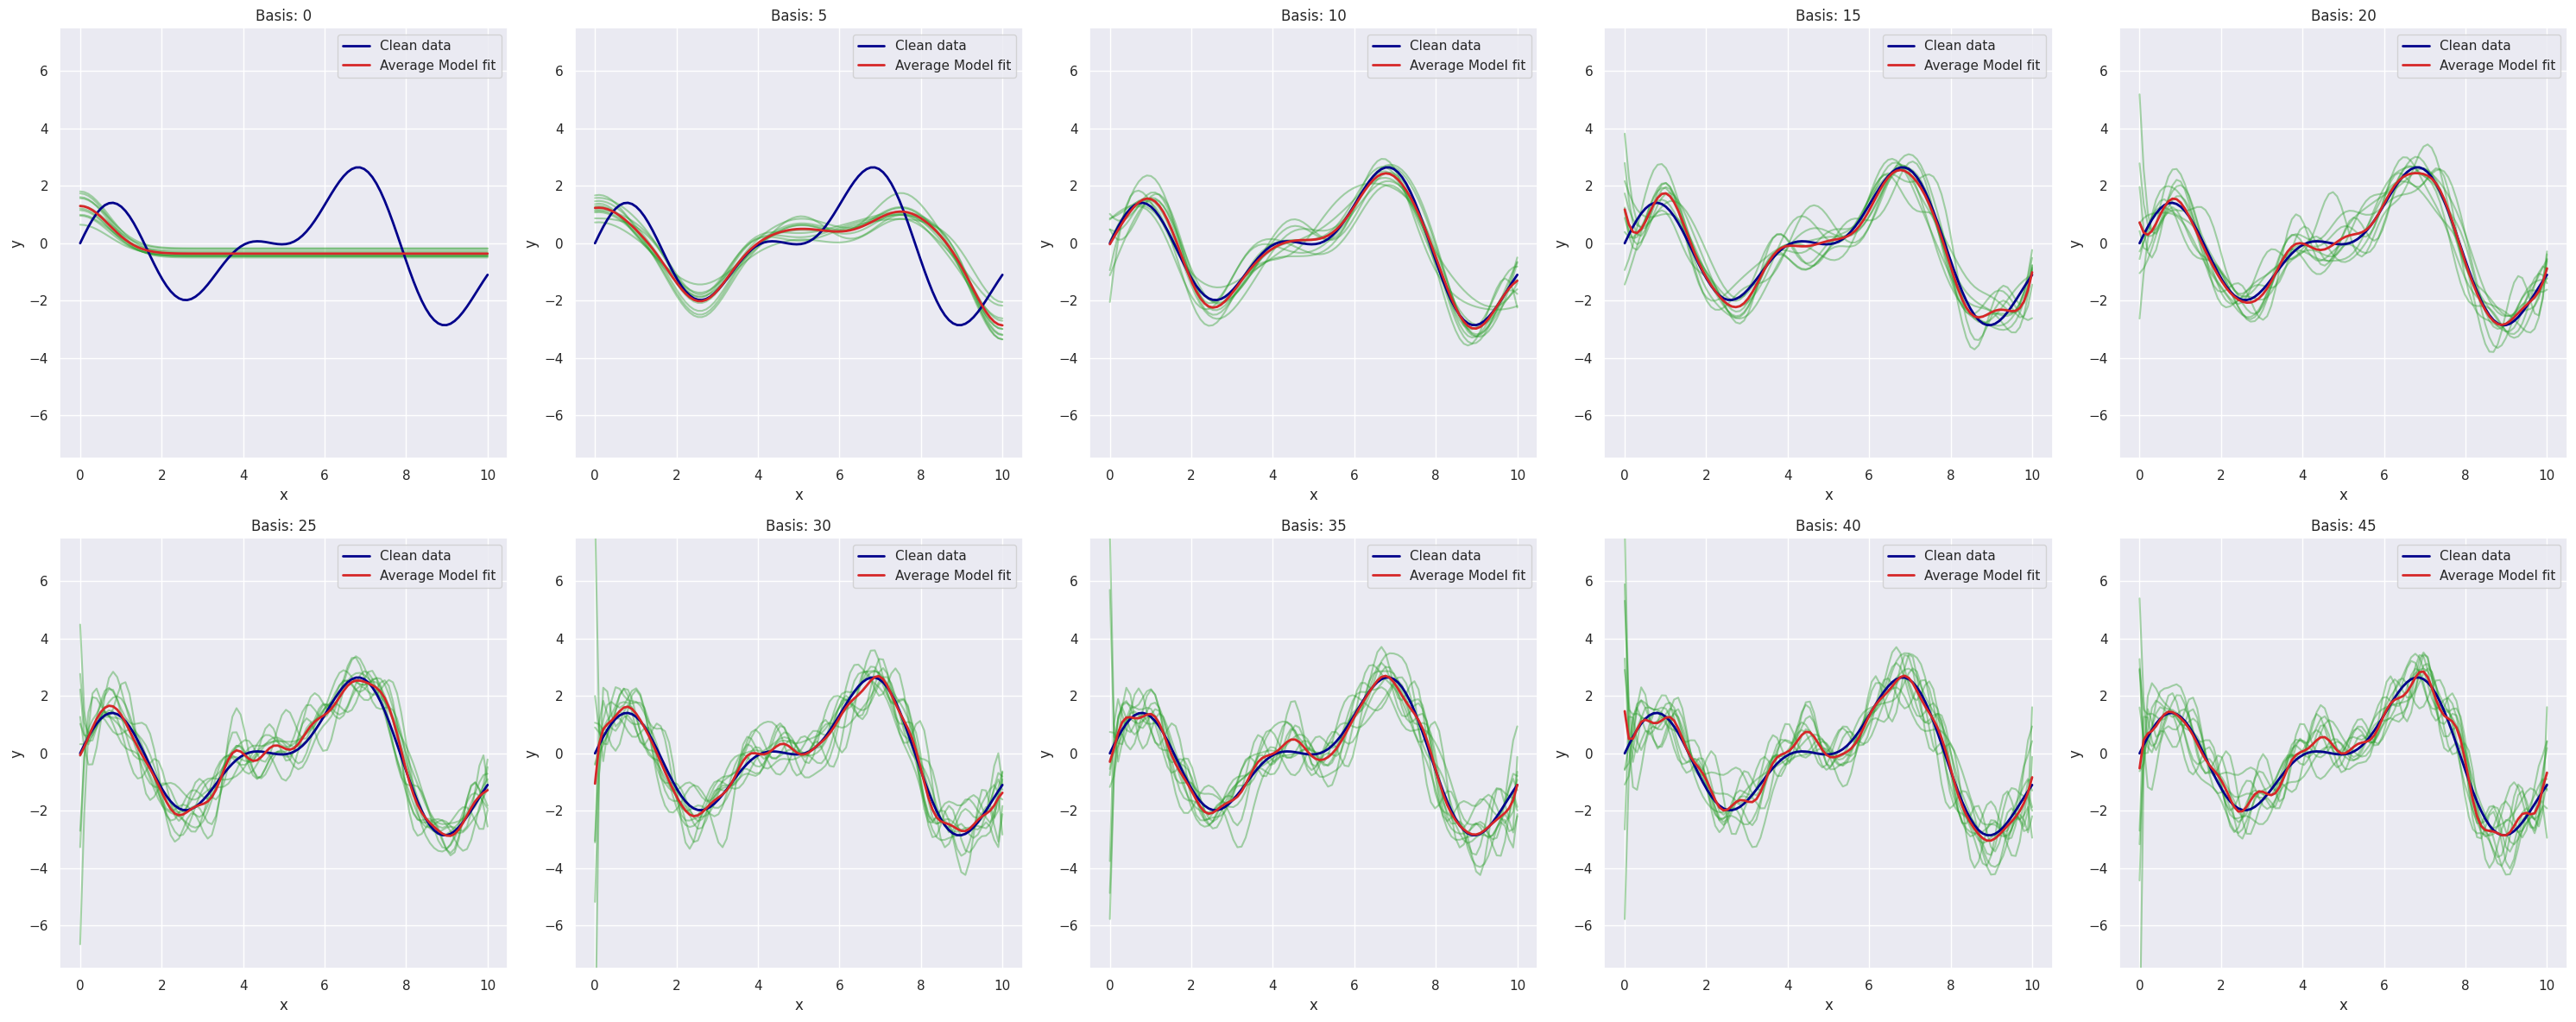

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(30, 12))
axs = axs.flatten()
for i, base in enumerate(bases):
  df = results[base]
  ax = axs[i]
  all_fits = np.array([r['y_pred'] for _, r in df.iterrows()])
  y_avg = np.mean(all_fits, axis=0)
  for fit in all_fits:
    ax.plot(x, fit, '-', color='tab:green', label='_nolegend_', alpha=0.4)
  ax.plot(x, y_clean, '-', label="Clean data", color='darkblue', linewidth=2)
  ax.plot(x, y_avg, '-', label="Average Model fit", color='tab:red', linewidth=2)

  ax.set_ylim(-7.5,7.5)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_title(f"Basis: {base}")
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

## 2.3 Plotting Train and Test Error

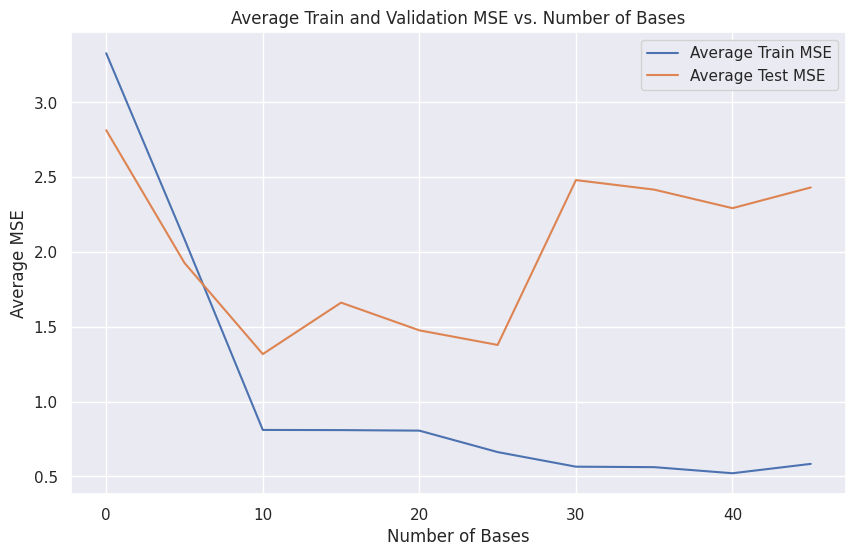

In [ ]:
average_test_mse = []
average_train_mse = []
for base in bases:
  df = results[base]
  train_mses = np.array([r['Train MSE'] for _, r in df.iterrows()])
  avg_train = np.mean(train_mses, axis=0)
  average_train_mse.append(avg_train)
  test_mses = np.array([r['Validation MSE'] for _, r in df.iterrows()])
  avg_test = np.mean(test_mses, axis=0)
  average_test_mse.append(avg_test)

plt.figure(figsize=(10, 6))
plt.plot(bases, average_train_mse, label='Average Train MSE')
plt.plot(bases, average_test_mse, label='Average Test MSE')
plt.xlabel('Number of Bases')
plt.ylabel('Average MSE')
plt.title('Average Train and Validation MSE vs. Number of Bases')
plt.legend()
plt.grid(True)
plt.show()

## 2.4 Explaining Bias and Variance

**Note:** See Section 2.2 of the report for detailed explanations.

# Task 3: Regularization with Cross-Validation

In [ ]:
'''
For bonus points added Elastic net regularization (combination of L1 and L2 regularization)
'''

## 3.1 Adding Regularization

## 3.2: Cross Validation

### Lambda1 and Lambda2 grid search

In [ ]:
lambda_ranges = np.concatenate((np.array([0]), np.logspace(-4, 0, 9)))

### Test size for orignal train test split
test_size = 0.1
x_main, x_test, y_main, y_test = train_test_split(x, y_noisy, test_size=test_size, random_state=42)


### Test size for splitting train into train and validation set
test_size = 0.1 * len(x)/len(x_main)
# print(len(x_main), len(x_test)) # Output: 90 10
# print(test_size * len(x_main)) # Output: 10
x_train, x_validation, y_train, y_validation = train_test_split(x_main, y_main, test_size=test_size, random_state=42)
# print(len(x_train), len(x_validation), len(x_test)) # Output: 80 10 10

column_names = ['Lambda1', 'Lambda2', 'Train MSE', 'Validation MSE']
df = pd.DataFrame()

num_folds = 10
for tr_inds, val_inds in cross_validate(len(x_main), num_folds, seed=42):
    x_train, y_train = x_main[tr_inds], y_main[tr_inds]
    x_validation, y_validation = x_main[val_inds], y_main[val_inds]

    ### We know the optimal number of bases is 11 from task 1.4
    optimal_base = 11
    xmin = x_train.min()
    xmax = x_train.max()
    mu = xmin + (xmax - xmin) / (optimal_base - 1) * np.arange(optimal_base) if optimal_base > 1 else np.array([0])

    phi_train = gaussian_basis_function(x_train[:, None], mu[None, :])
    phi_validation = gaussian_basis_function(x_validation[:, None], mu[None, :])

    for lambda1 in lambda_ranges:
        for lambda2 in lambda_ranges:
            model = LinearRegression(lambda1=lambda1, lambda2=lambda2)
            optimizer = GradientDescent(learning_rate=.5, max_iters=10000)

            # Fit the model on the training data (using phi_train)
            model.fit(phi_train, y_train, optimizer)

            # Predict on the train data (using phi_train)
            yh_train = model.predict(phi_train)
            train_mse = model.MSE(y_train, yh_train)

            # Predict on the validation data (using phi_validation)
            yh_validation = model.predict(phi_validation)
            validation_mse = model.MSE(y_validation, yh_validation)

            # Append the results to the DataFrame
            new_row = pd.DataFrame([[lambda1, lambda2, train_mse, validation_mse]], columns=column_names)
            df = pd.concat([df, new_row], ignore_index=True)


In [ ]:
# Pivot the DataFrame to get Lambda1 as columns and Lambda2 as rows, takes mean of each entry
df_pivot_train = df.pivot_table(index='Lambda2', columns='Lambda1', values='Train MSE')

# Display the pivoted DataFrame
display(df_pivot_train)

# Find the minimum value in the entire DataFrame
min_value = df_pivot_train.min().min()

# Find the column name of the minimum value
best_lambda1 = df_pivot_train.min().idxmin()

# Find the row name of the minimum value
best_lambda2 = df_pivot_train[best_lambda1].idxmin()

print(f"\nOptimal Lambda1: {best_lambda1}")
print(f"Optimal Lambda2: {best_lambda2}")
print(f"Minimum Train MSE: {min_value}")

# Find the optimial lambda1 or lambda2 independently
optimal_l1_lambda1 = df_pivot_train.loc[0.0, :].idxmin()
min_validation_mse_l1 = df_pivot_train.loc[0.0, optimal_l1_lambda1]
print(f"\nOptimal Lambda1 (L1 only): {optimal_l1_lambda1}")
print(f"Minimum Validation MSE (L1 only): {min_validation_mse_l1}")

optimal_l2_lambda2 = df_pivot_train.loc[:, 0.0].idxmin()
min_validation_mse_l2 = df_pivot_train.loc[optimal_l2_lambda2, 0.0]
print(f"\nOptimal Lambda2 (L2 only): {optimal_l2_lambda2}")
print(f"Minimum Validation MSE (L2 only): {min_validation_mse_l2}")

Lambda1   0.000000  0.000100  0.000316  0.001000  0.003162  0.010000  \
Lambda2                                                                
0.000000  0.775802  0.775873  0.776030  0.776502  0.778590  0.792662   
0.000100  0.775928  0.775991  0.776139  0.776618  0.778755  0.793052   
0.000316  0.776208  0.776263  0.776388  0.776889  0.779166  0.793823   
0.001000  0.777272  0.777323  0.777449  0.777995  0.780760  0.796475   
0.003162  0.782540  0.782640  0.782868  0.783749  0.787568  0.805653   
0.010000  0.808543  0.808787  0.809323  0.811095  0.817412  0.841104   
0.031623  0.923266  0.923728  0.924731  0.927938  0.938345  0.970603   
0.100000  1.302713  1.303236  1.304369  1.307972  1.319503  1.357752   
0.316228  2.070813  2.071312  2.072391  2.075806  2.086649  2.121341   
1.000000  2.866525  2.866802  2.867401  2.869297  2.875298  2.894350   

Lambda1   0.031623  0.100000  0.316228  1.000000  
Lambda2                                           
0.000000  0.875640  1.332446  3.254271  3.218549  
0.000100  0.876677  1.331729  3.200779  3.103989  
0.000316  0.878058  1.341820  3.163297  3.489573  
0.001000  0.882269  1.346952  3.162325  3.098836  
0.003162  0.896221  1.364030  3.141527  3.309834  
0.010000  0.941063  1.423285  3.211422  3.234537  
0.031623  1.087674  1.602992  3.197005  3.249273  
0.100000  1.493206  2.004750  3.261489  3.409264  
0.316228  2.234391  2.607715  3.286542  2.931224  
1.000000  2.954681  3.132527  3.188847  2.022035


Optimal Lambda1: 0.0
Optimal Lambda2: 0.0
Minimum Train MSE: 0.7758018717761253

Optimal Lambda1 (L1 only): 0.0
Minimum Validation MSE (L1 only): 0.7758018717761253

Optimal Lambda2 (L2 only): 0.0
Minimum Validation MSE (L2 only): 0.7758018717761253


In [ ]:
# Pivot the DataFrame to get Lambda1 as columns and Lambda2 as rows, takes mean of each entry
df_pivot_val = df.pivot_table(index='Lambda2', columns='Lambda1', values='Validation MSE')

# Display the pivoted DataFrame
display(df_pivot_val)

# Find the minimum value in the entire DataFrame
min_value = df_pivot_val.min().min()

# Find the column name of the minimum value
best_lambda1 = df_pivot_val.min().idxmin()

# Find the row name of the minimum value
best_lambda2 = df_pivot_val[best_lambda1].idxmin()

print(f"\nOptimal Lambda1: {best_lambda1}")
print(f"Optimal Lambda2: {best_lambda2}")
print(f"Minimum Validation MSE: {min_value}")

# Find the optimial lambda1 or lambda2 independently
optimal_l1_lambda1 = df_pivot_val.loc[0.0, :].idxmin()
min_validation_mse_l1 = df_pivot_val.loc[0.0, optimal_l1_lambda1]
print(f"\nOptimal Lambda1 (L1 only): {optimal_l1_lambda1}")
print(f"Minimum Validation MSE (L1 only): {min_validation_mse_l1}")

optimal_l2_lambda2 = df_pivot_val.loc[:, 0.0].idxmin()
min_validation_mse_l2 = df_pivot_val.loc[optimal_l2_lambda2, 0.0]
print(f"\nOptimal Lambda2 (L2 only): {optimal_l2_lambda2}")
print(f"Minimum Validation MSE (L2 only): {min_validation_mse_l2}")

Lambda1   0.000000  0.000100  0.000316  0.001000  0.003162  0.010000  \
Lambda2                                                                
0.000000  0.993175  0.991803  0.991154  0.989117  0.986453  1.000984   
0.000100  0.991083  0.990544  0.989520  0.987884  0.985464  1.001390   
0.000316  0.987257  0.986825  0.986559  0.985019  0.983029  0.999820   
0.001000  0.978683  0.978459  0.977983  0.976886  0.976484  0.995767   
0.003162  0.965088  0.965099  0.965134  0.965089  0.966146  0.989886   
0.010000  0.964568  0.964865  0.965516  0.967652  0.974127  0.999724   
0.031623  1.060667  1.061129  1.062131  1.065333  1.075516  1.108935   
0.100000  1.441123  1.441733  1.443054  1.447232  1.460523  1.501097   
0.316228  2.205403  2.205935  2.207087  2.210731  2.222291  2.258302   
1.000000  2.978414  2.978701  2.979321  2.981282  2.987357  3.006739   

Lambda1   0.031623  0.100000  0.316228  1.000000  
Lambda2                                           
0.000000  1.070729  1.580248  3.397223  3.745346  
0.000100  1.073766  1.584656  3.321266  3.655028  
0.000316  1.073027  1.583956  3.350325  3.846039  
0.001000  1.069328  1.593391  3.329101  3.412127  
0.003162  1.075531  1.599554  3.274079  3.687406  
0.010000  1.101893  1.654478  3.323664  3.760460  
0.031623  1.235969  1.809399  3.328552  3.795384  
0.100000  1.638921  2.173350  3.384894  3.706391  
0.316228  2.372801  2.744992  3.383634  3.434803  
1.000000  3.066786  3.219588  3.279326  2.826660


Optimal Lambda1: 0.0
Optimal Lambda2: 0.01
Minimum Validation MSE: 0.9645678972655858

Optimal Lambda1 (L1 only): 0.0031622776601683794
Minimum Validation MSE (L1 only): 0.9864527739253335

Optimal Lambda2 (L2 only): 0.01
Minimum Validation MSE (L2 only): 0.9645678972655858


## 3.3: Plotting Train and Validation Errors

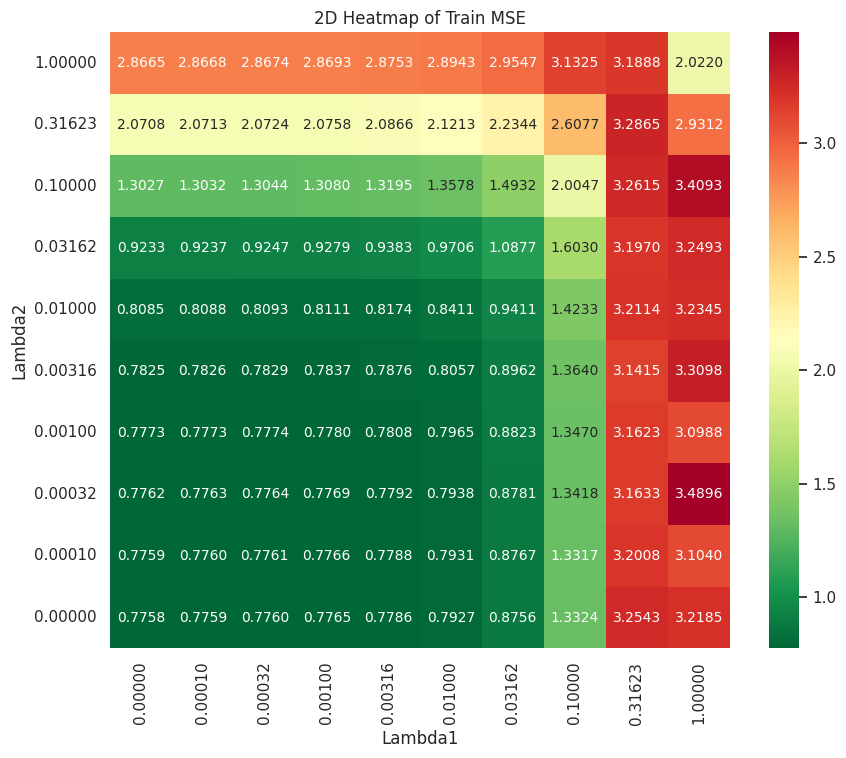

In [ ]:
import seaborn as sns

# 2D Heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_pivot_train, annot=True, fmt=".4f", annot_kws={"size": 10}, cmap="RdYlGn_r")
ax.invert_yaxis()
plt.title('2D Heatmap of Train MSE')
plt.xlabel('Lambda1')
plt.ylabel('Lambda2')
plt.xticks(ticks=np.arange(len(lambda_ranges)) + 0.5, labels=[f'{x:.5f}' for x in lambda_ranges]) # Rounded x-axis labels
plt.yticks(ticks=np.arange(len(lambda_ranges)) + 0.5, labels=[f'{y:.5f}' for y in lambda_ranges])
plt.show()

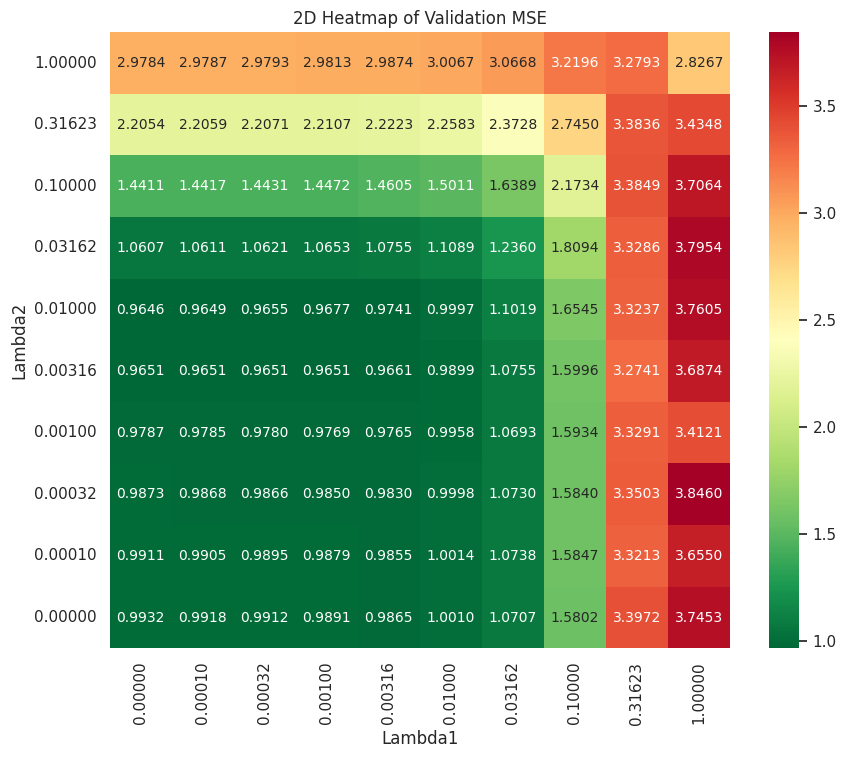

In [ ]:
import seaborn as sns

# 2D Heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_pivot_val, annot=True, fmt=".4f", annot_kws={"size": 10}, cmap="RdYlGn_r")
ax.invert_yaxis()
plt.title('2D Heatmap of Validation MSE')
plt.xlabel('Lambda1')
plt.ylabel('Lambda2')
plt.xticks(ticks=np.arange(len(lambda_ranges)) + 0.5, labels=[f'{x:.5f}' for x in lambda_ranges]) # Rounded x-axis labels
plt.yticks(ticks=np.arange(len(lambda_ranges)) + 0.5, labels=[f'{y:.5f}' for y in lambda_ranges])
plt.show()

## 3.4: Plotting Bias-Variance Decomposition

In [ ]:
lambda_ranges = np.concatenate((np.array([0]), np.logspace(-4, 0, 9)))
test_size = 0.1
num_folds = 10
bases = 11

### Split data 8:1:1 train/validation/test
x_main, x_test, y_main_noisy, y_test_noisy = train_test_split(x, y_noisy, test_size=test_size, random_state=42)
_, y_test_clean = train_test_split(y_clean, test_size=test_size, random_state=42)
noise_variance_empirical = np.var(y_test_noisy - y_test_clean)

column_names = ["Fold",'Lambda1', 'Lambda2', 'Train SSE', 'Validation SSE']
df_lambda1 = pd.DataFrame()
df_lambda2 = pd.DataFrame()

# Function to calculate Bias-Variance breakdown for L1 and L2
def evaluate_regularization(reg_type):
    column_names = ["Fold",'Lambda', 'Train MSE', 'Validation MSE']
    df = pd.DataFrame()
    test_predictions = [np.zeros((len(x_test), num_folds)) for _ in lambda_ranges]

    for fold_i, (tr_inds, val_inds) in enumerate(cross_validate(len(x_main), num_folds, seed=42)):
        x_train, y_train = x_main[tr_inds], y_main_noisy[tr_inds]
        x_validation, y_validation = x_main[val_inds], y_main_noisy[val_inds]

        ### We know the optimal number of bases is 11 from task 1.4
        optimal_base = 11
        xmin = x_train.min()
        xmax = x_train.max()
        mu = xmin + (xmax - xmin) / (optimal_base - 1) * np.arange(optimal_base) if optimal_base > 1 else np.array([0])

        phi_train = gaussian_basis_function(x_train[:, None], mu[None, :])
        phi_validation = gaussian_basis_function(x_validation[:, None], mu[None, :])
        phi_test = gaussian_basis_function(x_test[:, None], mu[None, :])

        for j, lambda_value in enumerate(lambda_ranges):
            l1, l2 = (lambda_value, 0) if reg_type == 'L1' else (0, lambda_value)
            model = LinearRegression(lambda1=l1, lambda2=l2)
            optimizer = GradientDescent(learning_rate=.5, max_iters=10000)

            # Fit the model on the training data (using phi_train)
            model.fit(phi_train, y_train, optimizer)

            # Predict on the train data (using phi_train)
            yh_train = model.predict(phi_train)
            train_mse = model.MSE(y_train, yh_train)

            # Predict on the validation data (using phi_validation)
            yh_validation = model.predict(phi_validation)
            validation_mse = model.MSE(y_validation, yh_validation)

            # Append the results to the DataFrame
            new_row = pd.DataFrame([[fold_i, lambda_value, train_mse, validation_mse]], columns=column_names)
            df = pd.concat([df, new_row], ignore_index=True)

            yh_test = model.predict(phi_test)
            test_predictions[j][:, fold_i] = yh_test

    results = []
    for j, lambda_value in enumerate(lambda_ranges):
        preds = test_predictions[j]
        avg_pred = preds.mean(axis=1)
        bias_sq = np.mean((avg_pred - y_test_clean)**2)
        variance = np.mean(np.var(preds, axis=1))
        results.append({
            'Lambda': lambda_value,
            'Bias^2': bias_sq,
            'Variance': variance,
            'Noise Variance': noise_variance_empirical,
            'Train MSE': df[df['Lambda'] == lambda_value]['Train MSE'].mean(),
            'Test MSE': df[df['Lambda'] == lambda_value]['Validation MSE'].mean()
        })

    return pd.DataFrame(results)


# Run for both L1 and L2
l1_bv_df = evaluate_regularization('L1')
l2_bv_df = evaluate_regularization('L2')

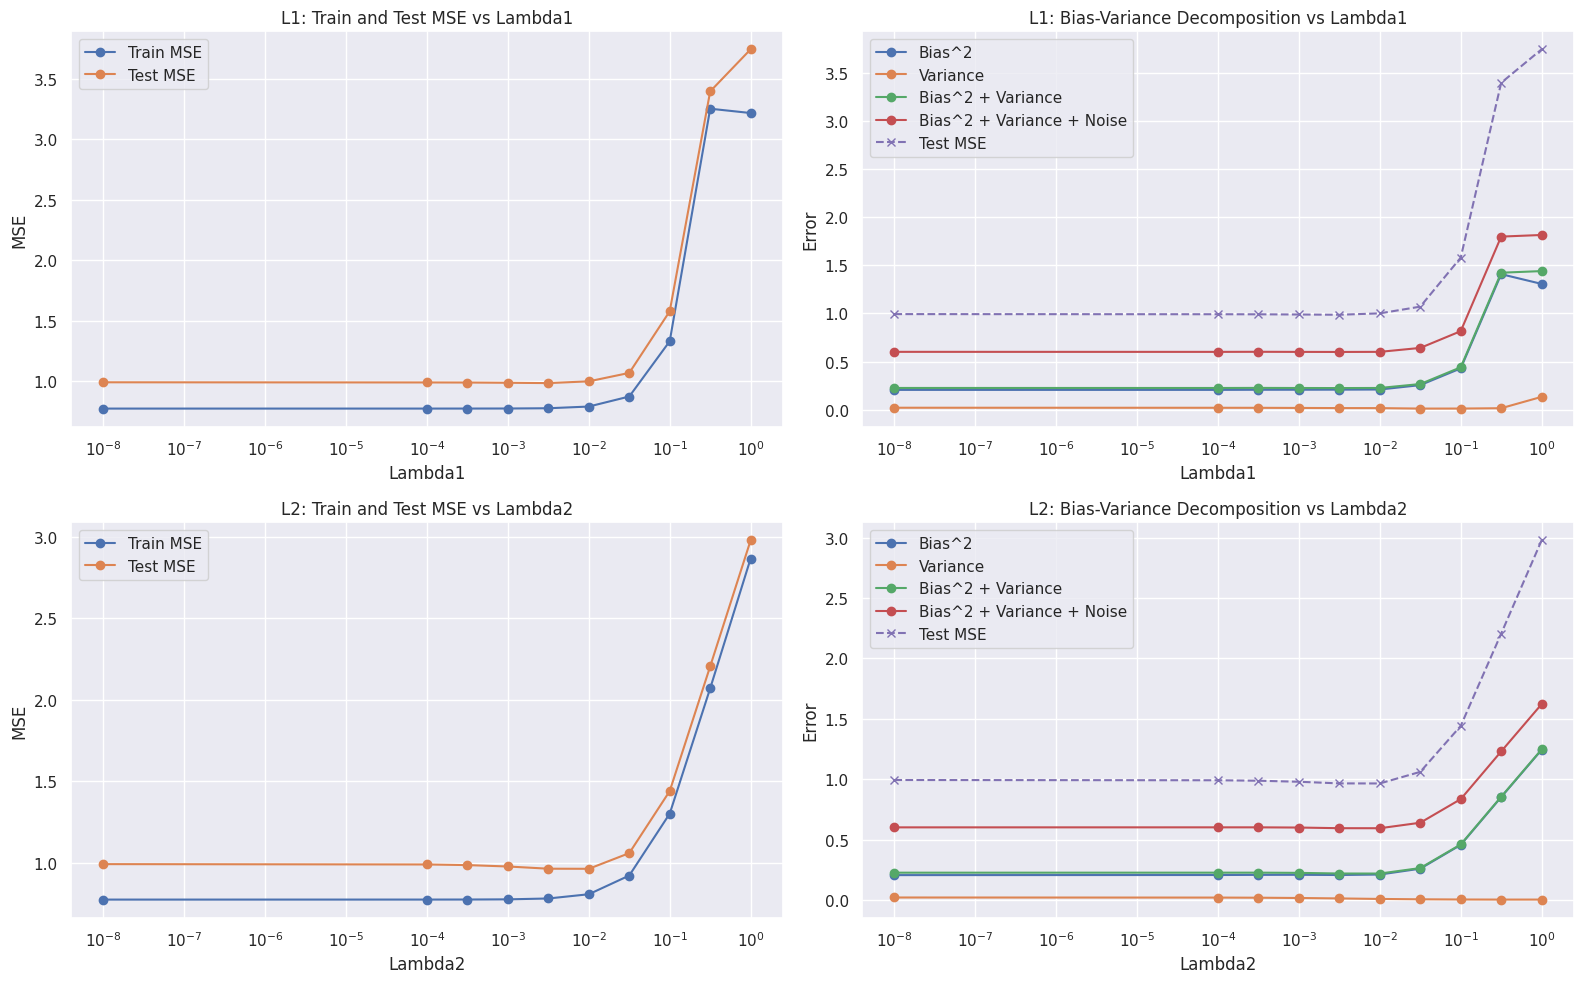

In [ ]:
x_vals = np.concatenate((np.array([1e-8]), np.logspace(-4, 0, 9)))

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
# L1 Train/Test
axes[0,0].plot(x_vals, l1_bv_df['Train MSE'], marker='o', label='Train MSE')
axes[0,0].plot(x_vals, l1_bv_df['Test MSE'], marker='o', label='Test MSE')
axes[0,0].set_xscale('log')
axes[0,0].set_title('L1: Train and Test MSE vs Lambda1')
axes[0,0].set_xlabel('Lambda1')
axes[0,0].set_ylabel('MSE')
axes[0,0].legend()
axes[0,0].grid(True)

# L1 BV decomposition
axes[0,1].plot(x_vals, l1_bv_df['Bias^2'], marker='o', label='Bias^2')
axes[0,1].plot(x_vals, l1_bv_df['Variance'], marker='o', label='Variance')
axes[0,1].plot(x_vals, l1_bv_df['Bias^2'] + l1_bv_df['Variance'], marker='o', label='Bias^2 + Variance')
axes[0,1].plot(x_vals, l1_bv_df['Bias^2'] + l1_bv_df['Variance'] + l1_bv_df['Noise Variance'], marker='o', label='Bias^2 + Variance + Noise')
axes[0,1].plot(x_vals, l1_bv_df['Test MSE'], marker='x', linestyle='--', label='Test MSE')
axes[0,1].set_xscale('log')
axes[0,1].set_title('L1: Bias-Variance Decomposition vs Lambda1')
axes[0,1].set_xlabel('Lambda1')
axes[0,1].set_ylabel('Error')
axes[0,1].legend()
axes[0,1].grid(True)

# L2 Train/Test
axes[1,0].plot(x_vals, l2_bv_df['Train MSE'], marker='o', label='Train MSE')
axes[1,0].plot(x_vals, l2_bv_df['Test MSE'], marker='o', label='Test MSE')
axes[1,0].set_xscale('log')
axes[1,0].set_title('L2: Train and Test MSE vs Lambda2')
axes[1,0].set_xlabel('Lambda2')
axes[1,0].set_ylabel('MSE')
axes[1,0].legend()
axes[1,0].grid(True)

# L2 BV decomposition
axes[1,1].plot(x_vals, l2_bv_df['Bias^2'], marker='o', label='Bias^2')
axes[1,1].plot(x_vals, l2_bv_df['Variance'], marker='o', label='Variance')
axes[1,1].plot(x_vals, l2_bv_df['Bias^2'] + l2_bv_df['Variance'], marker='o', label='Bias^2 + Variance')
axes[1,1].plot(x_vals, l2_bv_df['Bias^2'] + l2_bv_df['Variance'] + l2_bv_df['Noise Variance'], marker='o', label='Bias^2 + Variance + Noise')
axes[1,1].plot(x_vals, l2_bv_df['Test MSE'], marker='x', linestyle='--', label='Test MSE')
axes[1,1].set_xscale('log')
axes[1,1].set_title('L2: Bias-Variance Decomposition vs Lambda2')
axes[1,1].set_xlabel('Lambda2')
axes[1,1].set_ylabel('Error')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

## 3.5: Selecting the Optimal λ

**Note:** See Section 2.3 of the report for detailed explanations.

# Task 4: Effect of L1 and L2 Regularization on Loss

## 4.1: Generating Synthetic Data

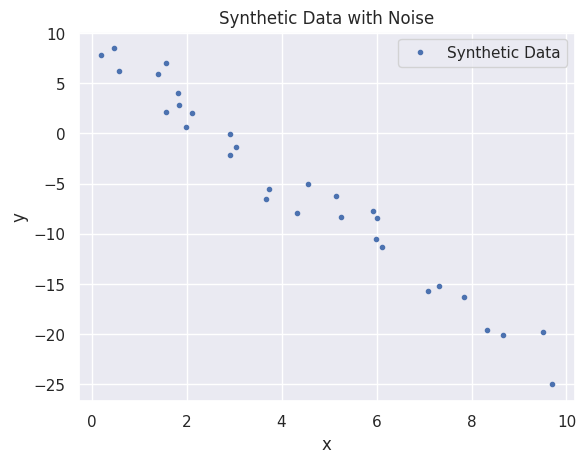

In [ ]:
N = 30

np.random.seed(42)
x = np.random.uniform(0, 10, N)
e = np.random.normal(0, 1, N)
y = -3 * x + 8 + 2 * e

plt.plot(x, y, ".", label="Synthetic Data")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Data with Noise')

plt.legend()
plt.show()

## 4.2: Applying L1 and L2 Regularization

### L1 Regularization

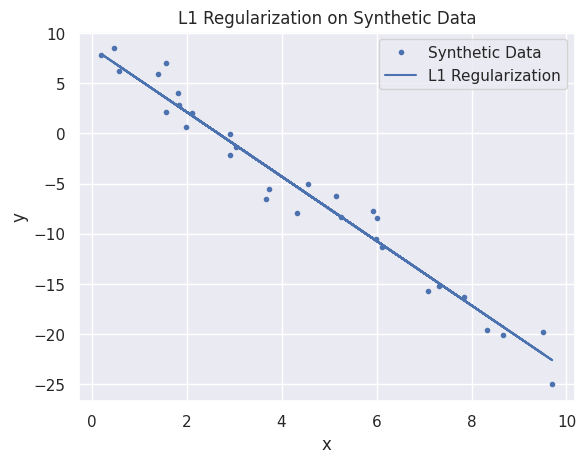

In [ ]:
descent = GradientDescent(learning_rate=0.01, max_iters=50000)

l1_reg = LinearRegression(lambda1=0.5)
l1_reg.fit(x, y, descent)
yh = l1_reg.predict(x)

plt.plot(x, y, ".", label="Synthetic Data")
plt.plot(x, yh, "b-", label="L1 Regularization")
plt.xlabel("x")
plt.ylabel("y")
plt.title("L1 Regularization on Synthetic Data")

plt.legend()
plt.show()

### L2 Regularization

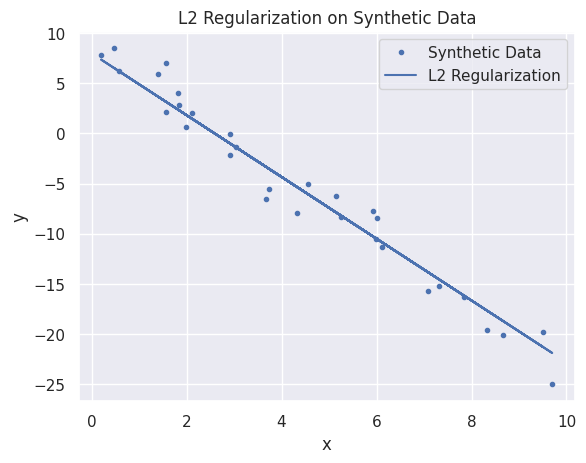

In [ ]:
descent = GradientDescent(learning_rate=0.01, max_iters=50000)

l2_reg = LinearRegression(lambda2=0.5)
l2_reg.fit(x, y, descent)
yh = l2_reg.predict(x)

plt.plot(x, y, ".", label="Synthetic Data")
plt.plot(x, yh, "b-", label="L2 Regularization")
plt.xlabel("x")
plt.ylabel("y")
plt.title("L2 Regularization on Synthetic Data")

plt.legend()
plt.show()

## 4.3: Plotting the Loss Function

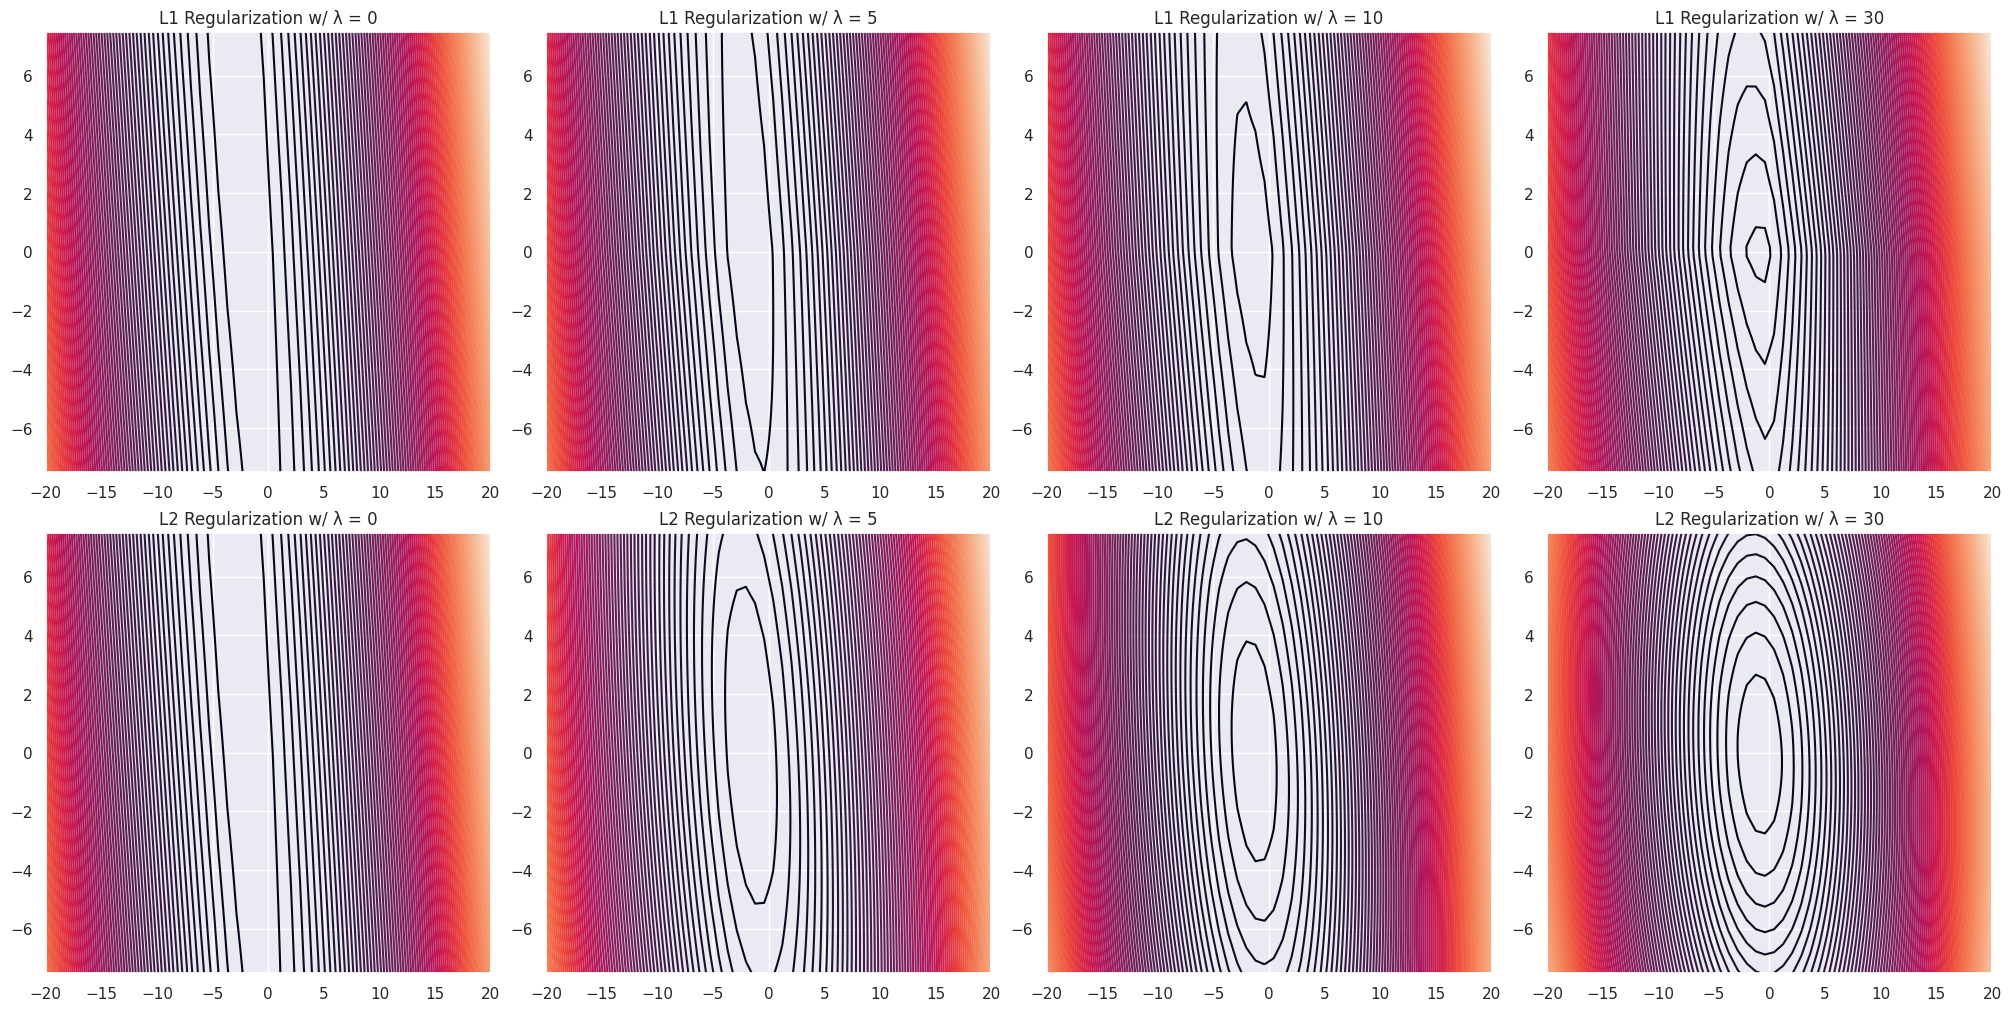

In [ ]:
# penalize both weights (for visualization)

cost = lambda w: 0.5 * np.mean((w[1] + w[0] * x - y) ** 2)
l2_penalty = lambda w: np.dot(w, w) / 2
l1_penalty = lambda w: np.sum(np.abs(w))

def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i, j in itertools.product(range(resolution), range(resolution)):
        zg[i, j] = f([xg[i, j], yg[i, j]])
    ax.contour(xg, yg, zg, 100)
    return ax

lambdas = [0, 5, 10, 30]

fig, axes = plt.subplots(nrows=2, ncols=len(lambdas), constrained_layout=True, figsize=(20, 10))

# l1 regularization
for i, l in enumerate(lambdas):
  cost_l1 = lambda w: cost(w) + l * l1_penalty(w)

  plot_contour(cost_l1, [-20, 20], [-7.5, 7.5], 50, axes[0, i])
  axes[0, i].set_title(f"L1 Regularization w/ λ = {l}")

# l2 regularization
for i, l in enumerate(lambdas):
  cost_l2 = lambda w: cost(w) + l * l2_penalty(w)

  plot_contour(cost_l2, [-20, 20], [-7.5, 7.5], 50, axes[1, i])
  axes[1, i].set_title(f"L2 Regularization w/ λ = {l}")
plt.show()

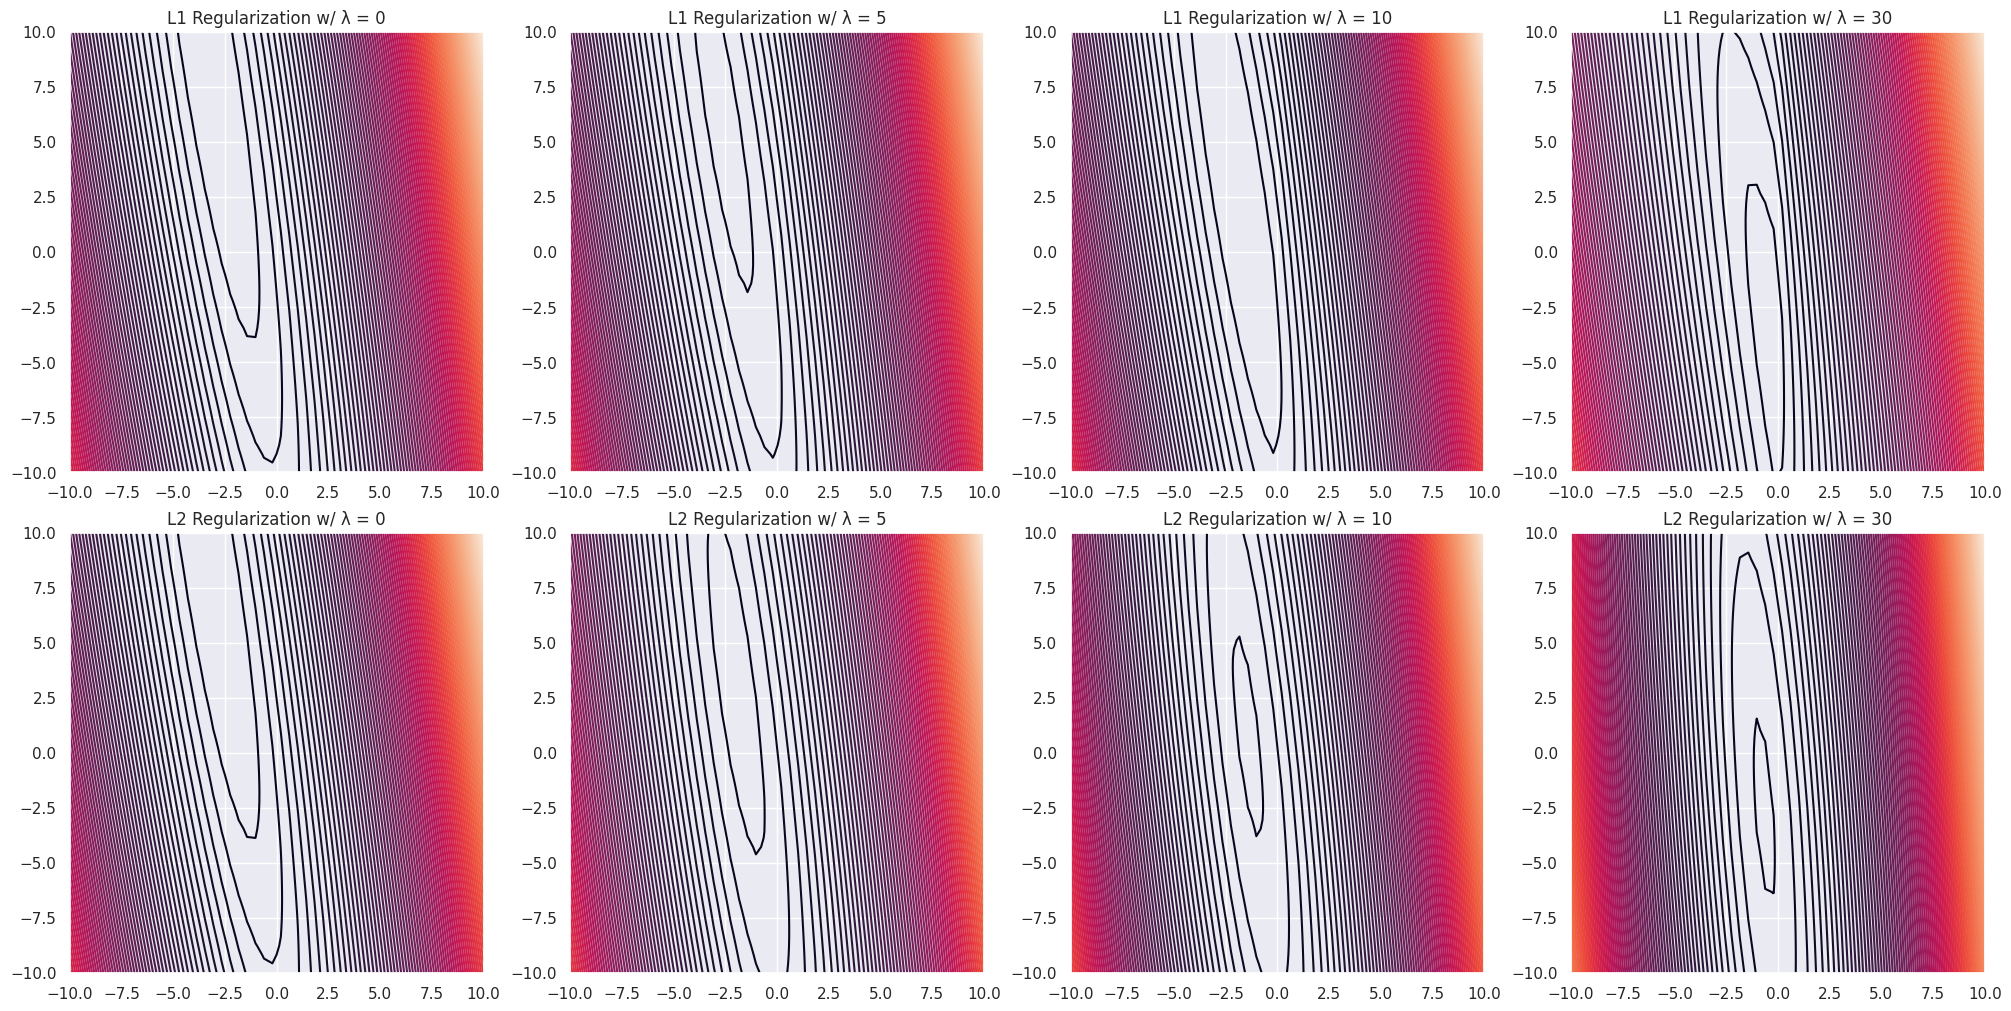

In [ ]:
# not penalizing the bias (in accordance with the assignment)

cost = lambda w: 0.5 * np.mean((w[1] + w[0] * x - y) ** 2)
l2_penalty = lambda w: np.dot(w[:1], w[:1]) / 2
l1_penalty = lambda w: np.sum(np.abs(w[:1]))

def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i, j in itertools.product(range(resolution), range(resolution)):
        zg[i, j] = f([xg[i, j], yg[i, j]])
    ax.contour(xg, yg, zg, 100)
    return ax

lambdas = [0, 5, 10, 30]

fig, axes = plt.subplots(nrows=2, ncols=len(lambdas), constrained_layout=True, figsize=(20, 10))

# l1 regularization
for i, l in enumerate(lambdas):
  cost_l1 = lambda w: cost(w) + l * l1_penalty(w)

  plot_contour(cost_l1, [-10, 10], [-10, 10], 50, axes[0, i])
  axes[0, i].set_title(f"L1 Regularization w/ λ = {l}")

# l2 regularization
for i, l in enumerate(lambdas):
  cost_l2 = lambda w: cost(w) + l * l2_penalty(w)

  plot_contour(cost_l2, [-10, 10], [-10, 10], 50, axes[1, i])
  axes[1, i].set_title(f"L2 Regularization w/ λ = {l}")
plt.show()

## 4.4: Visualizing Gradient Descent

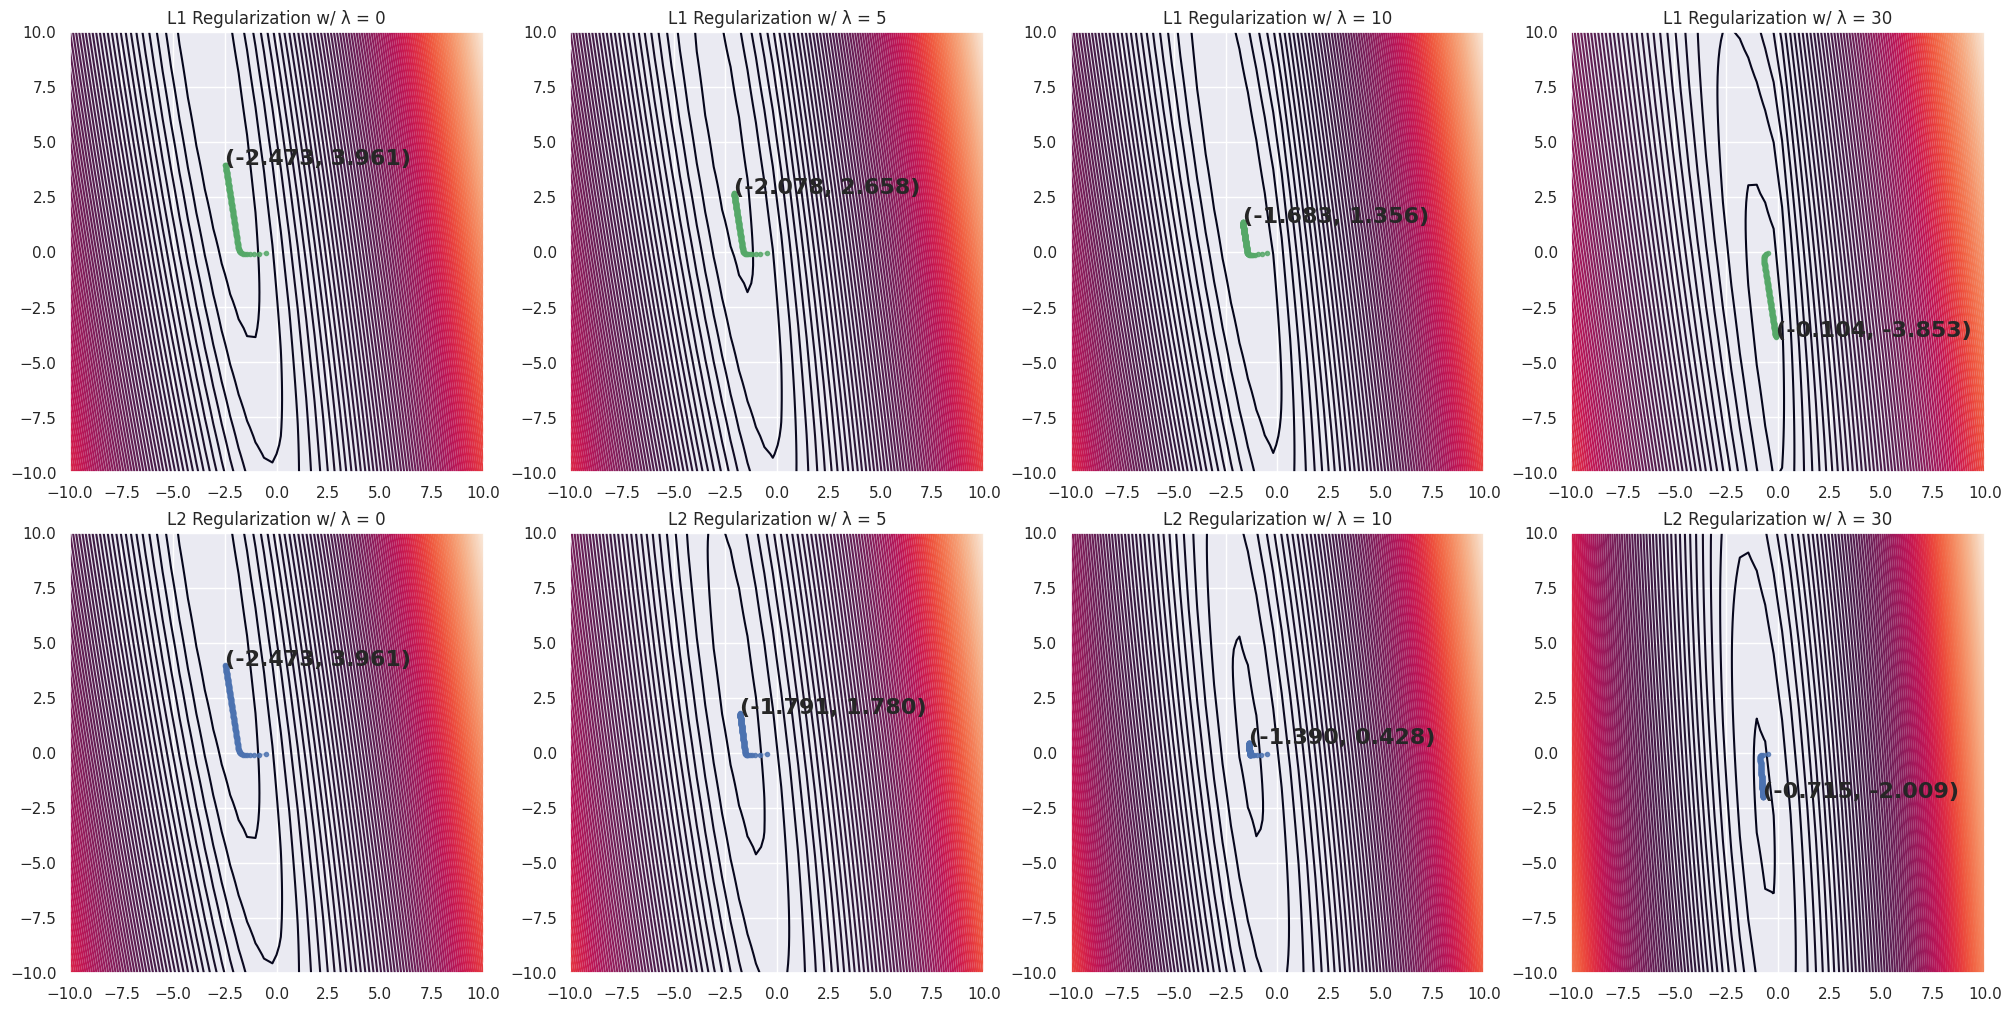

In [ ]:
lambdas = [0, 5, 10, 30]

fig, axes = plt.subplots(nrows=2, ncols=len(lambdas), constrained_layout=True,
                         figsize=(20, 10))
# l1 regularization
for i, l in enumerate(lambdas):
  cost_l1 = lambda w: cost(w) + l * l1_penalty(w)

  descent = GradientDescent(learning_rate=0.01, max_iters=225, record_history=True)
  l1_reg = LinearRegression(lambda1=l)
  l1_reg.fit(x, y, descent)

  plot_contour(cost_l1, [-10, 10], [-10, 10], 50, axes[0,i])
  weight_history = np.vstack(descent.w_history)

  axes[0,i].plot(weight_history[:, 0], weight_history[:, 1], '.g', alpha=0.8)
  axes[0,i].plot(weight_history[:, 0], weight_history[:, 1], '-g', alpha=0.3)

  final = weight_history[-1]
  axes[0,i].annotate(f"({final[0]:.3f}, {final[1]:.3f})", xy=(final[0], final[1]),
                      fontsize=16, fontweight='bold')
  axes[0,i].set_title(f"L1 Regularization w/ λ = {l}")

# l2 regularization
for i, l in enumerate(lambdas):
  cost_l2 = lambda w: cost(w) + l * l2_penalty(w)

  descent = GradientDescent(learning_rate=0.01, max_iters=225, record_history=True)
  l2_reg = LinearRegression(lambda2=l)
  l2_reg.fit(x, y, descent)

  plot_contour(cost_l2, [-10, 10], [-10, 10], 50, axes[1,i])
  weight_history = np.vstack(descent.w_history)

  axes[1,i].plot(weight_history[:, 0], weight_history[:, 1], '.b', alpha=0.8)
  axes[1,i].plot(weight_history[:, 0], weight_history[:, 1], '-b', alpha=0.3)

  final = weight_history[-1]
  axes[1,i].annotate(f"({final[0]:.3f}, {final[1]:.3f})", xy=(final[0], final[1]),
                      fontsize=16, fontweight='bold')
  axes[1,i].set_title(f"L2 Regularization w/ λ = {l}")
plt.show()


## 4.5: Analyzing the Effects of L1 and L2 Regularization

**Note:** See Section 2.4 of the report for detailed explanations.